In [2]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Обучается на: ", device)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) # случайная перестановка индексов 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Обучается на:  cpu


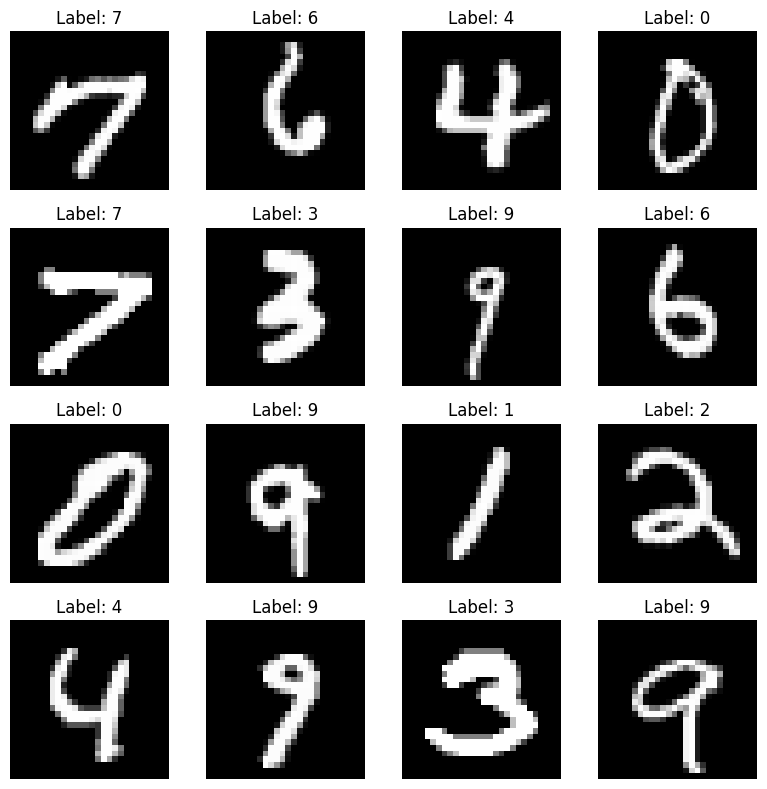

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, (images, labels) in enumerate(train_loader):
    for j in range(16):
        if i * 16 + j >= len(train_dataset):
            break
        ax = axes[j // 4, j % 4]
        image = images[j].numpy().squeeze()
        label = labels[j].item()

        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128) #28x28 разрешение изображений датасета
        self.relu = nn.ReLU() # Функция активации
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        
model = SNN()

In [16]:
criterion = nn.CrossEntropyLoss() #Метрика для оценки точности
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adaptive Moment Estimation алгоритм обновления параметров NN

num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
all_labels, all_predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

cm = confusion_matrix(all_labels, all_predictions) #матрица ошибок True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)

Epoch [1/5], Loss: 0.6988
Epoch [2/5], Loss: 0.1864
Epoch [3/5], Loss: 0.0761
Epoch [4/5], Loss: 0.2682
Epoch [5/5], Loss: 0.0489


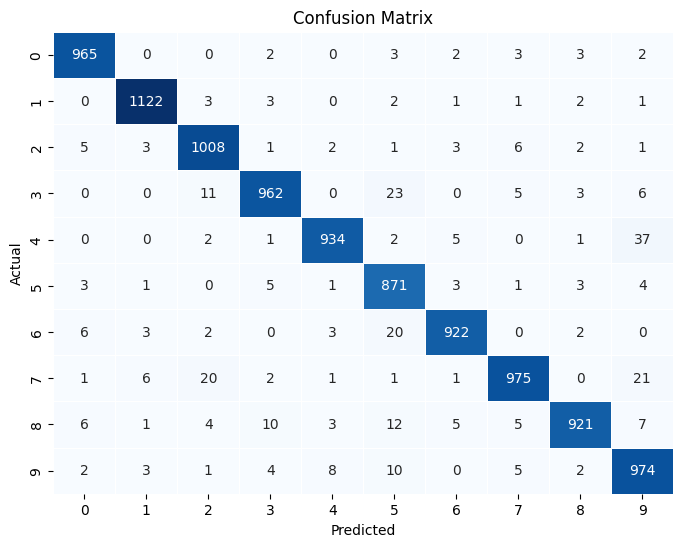

Test Accuracy: 96.54%


In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10), linewidths=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy:.2%}')

In [18]:
class NN2(nn.Module):
    def __init__(self):
        super(NN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
model = NN2()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []

num_epochs = 5
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

Epoch [1/5], Loss: 0.1563
Epoch [2/5], Loss: 0.0455
Epoch [3/5], Loss: 0.0312
Epoch [4/5], Loss: 0.0230
Epoch [5/5], Loss: 0.0180


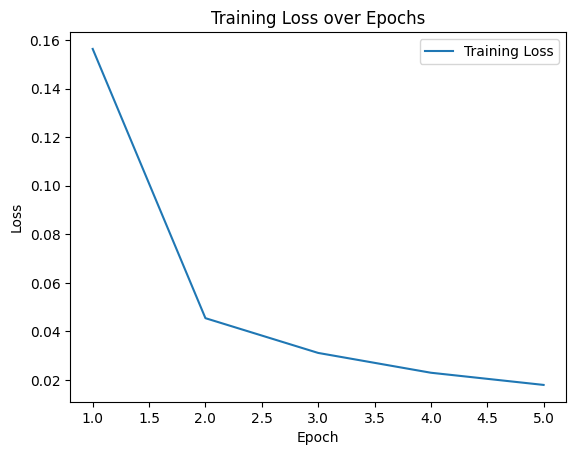

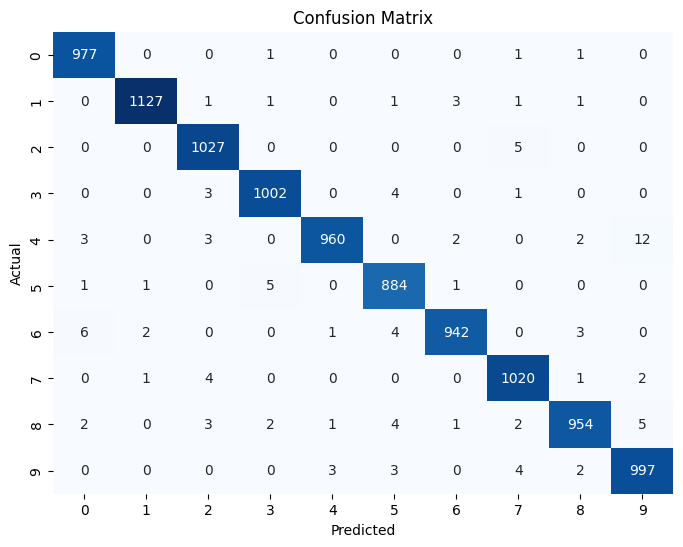

Test Accuracy: 98.90%


In [22]:
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

model.eval()
all_labels, all_predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy:.2%}')

In [23]:
torch.save(model.state_dict(), "mnist_NN2.pth")
print("Модель сохранена в файл mnist_NN2.pth")

Модель сохранена в файл mnist_NN2.pth


In [24]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader)
accuracy = 100.0 * correct / len(test_loader.dataset)

print(f"\nTest set: Average loss: {test_loss:.4f}, "
      f"Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")


Test set: Average loss: 0.0329, Accuracy: 9890/10000 (98.90%)

